# 模型训练

In [1]:
#  导入数据
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# 读取前1000行
# train_data = pd.read_csv('train_all.csv', nrows=1000)
# test_data = pd.read_csv('test_all.csv', nrows=1000)

# 读取全部数据
train_data = pd.read_csv('train_all.csv', nrows=None)
test_data = pd.read_csv('test_all.csv', nrows=None)

# 训练数据和测试数据处理
feature_columns = [col for col in train_data.columns if col not in ['user_id', 'label']]
train = train_data[feature_columns].values
test = test_data[feature_columns].values
target = train_data['label'].values


# folds = 5
# kf = KFold(n_splits=folds, shuffle=True, random_state=2021)

# for idx, (train_index, test_index) for enumerate(kf.split(ttain)):
#     train_x = train[train_index]
#     train_y = target[train_index]
#     test_x = test[test_index]
#     test_y = target[test_index]


# 切分数据
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.4, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_train.shape)

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)


(156518, 230) (156518,)
(104346, 230) (156518,)


0.9387710118260403

In [3]:
# 简单验证
from sklearn.model_selection import cross_val_score

# clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)
# clf = clf.fit(X_train, y_train)

scores = cross_val_score(clf, train, target, cv=5)
print(scores)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

[0.93885726 0.93885726 0.9388381  0.9388381  0.93885609]
Accuracy: 0.94 (+/- 0.00)


In [4]:
# F1值进行评价
"""
'micro':Calculate metrics globally by counting the total true positives, false negatives and false positives.
'micro':通过先计算总体的TP，FN和FP的数量，再计算F1
'macro':Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
'macro':分布计算每个类别的F1，然后做平均（各类别F1的权重相同）
"""

scores = cross_val_score(clf, train, target, cv=5, scoring='f1_macro')
print(scores)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

[0.48423227 0.48423227 0.48422718 0.48422718 0.48423196]
Accuracy: 0.48 (+/- 0.00)


In [5]:
# 交叉验证
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(clf, train, target, cv=cv)

array([0.93870432, 0.93828265, 0.93956044, 0.94040378, 0.93763097])

In [6]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
for k, (train_index, test_index) in enumerate(kf.split(train)):
    x_train, x_test, y_train, y_test = train[train_index], train[test_index], target[train_index], target[test_index]
    clf = clf.fit(x_train, y_train)
    print(k, clf.score(x_test, y_test))

0 0.9395089414064746
1 0.9386272593103713
2 0.9374005711766623
3 0.9398539474440802
4 0.9388560913900177


In [7]:
# 分组切分数据
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)
for k, (train_index, test_index) in enumerate(kf.split(train, target)):
    x_train, x_test, y_train, y_test = train[train_index], train[test_index], target[train_index], target[test_index]
    clf = clf.fit(x_train, y_train)
    print(k, clf.score(x_test, y_test))

0 0.9388572633354417
1 0.9388572633354417
2 0.9388380963333525
3 0.9388380963333525
4 0.9388560913900177


In [10]:
# 模型调参
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.5, random_state=0)

# model
clf = RandomForestClassifier(n_jobs=-1)
tune_parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 5],
    'max_features': ['log2', 'sqrt', 'int'],
    'bootstrap': [True, False],
    'warm_start': [True, False],
}

scores = ['precision']
for score in scores:
    print('Tune hyper-parameters for %s' % score)
    print()

    clf = GridSearchCV(clf, tune_parameters, cv=5, scoring='%s_macro'  % score)
    clf.fit(X_train, y_train)
    print('Best parameters set found on development set:')
    print()
    print(clf.best_params_)
    print()
    print('Grid scores on development set:')
    print()
    mean = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(mean, stds, clf.cv_results_):
        print('%0.3f (+/-%0.03f) for %r' % (mean, std * 2, params))
        print()
        print('Detailed classification report:')
        print()
        print('The model is trained on the full develoment set.')
        print('The scores are computed on the full evaluation set.')
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

Tune hyper-parameters for precision

Best parameters set found on development set:

{'bootstrap': True, 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 50, 'warm_start': True}

Grid scores on development set:

0.469 (+/-0.000) for 'mean_fit_time'

Detailed classification report:

The model is trained on the full develoment set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97    122462
         1.0       0.00      0.00      0.00      7970

    accuracy                           0.94    130432
   macro avg       0.47      0.50      0.48    130432
weighted avg       0.88      0.94      0.91    130432


0.469 (+/-0.000) for 'std_fit_time'

Detailed classification report:

The model is trained on the full develoment set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97    122462


              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97    122462
         1.0       0.00      0.00      0.00      7970

    accuracy                           0.94    130432
   macro avg       0.47      0.50      0.48    130432
weighted avg       0.88      0.94      0.91    130432


nan (+/-nan) for 'rank_test_score'

Detailed classification report:

The model is trained on the full develoment set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97    122462
         1.0       0.00      0.00      0.00      7970

    accuracy                           0.94    130432
   macro avg       0.47      0.50      0.48    130432
weighted avg       0.88      0.94      0.91    130432




Confusion matrix, Without normaliation
[[61124    90]
 [ 3980    22]]
Confusion matrix normalization
[[1.   0.  ]
 [0.99 0.01]]


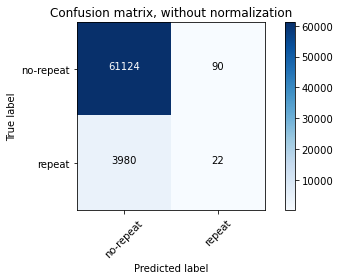

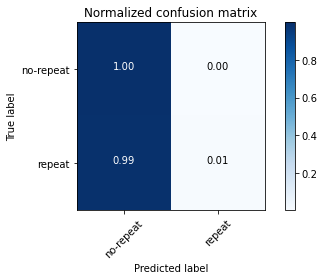

In [14]:

# 混淆矩阵
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# label_name
class_names = ['no-repeat', 'repeat']
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)
clf = RandomForestClassifier(n_jobs=-1)
y_pred = clf.fit(X_train, y_train).predict(X_test)

def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix,
    Normalization can be applied by setting 'normalize=True'
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Confusion matrix normalization')
    else:
        print('Confusion matrix, Without normaliation')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,
                 i,
                 format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=class_names,
                      normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [17]:
# 逻辑回归模型
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
X_train, X_test, y_train, y_test =  train_test_split(X, target, random_state=0)
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
clf.score(X_test, y_test)

0.9386193572129539

In [18]:
# KNN 模型
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
X_train, X_test, y_train, y_test =  train_test_split(X, target, random_state=0)

knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9386193572129539

In [21]:
# 高斯贝叶斯模型
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
X_train, X_test, y_train, y_test =  train_test_split(X, target, random_state=0)

clf = GaussianNB().fit(X_train, y_train)
clf.score(X_test, y_test)

0.7291615554465162

In [22]:
# 决策树模型
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
X_train, X_test, y_train, y_test =  train_test_split(X, target, random_state=0)

clf = DecisionTreeClassifier().fit(X_train, y_train)
clf.score(X_test, y_test)

0.8817621442590775

In [ ]:
# Bagging模型
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
X_train, X_test, y_train, y_test =  train_test_split(X, target, random_state=0)

clf = BaggingClassifier(base_estimator=KNeighborsClassifier(), max_samples=0.5, max_features=0.5).fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
# 随机森林模型
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
X_train, X_test, y_train, y_test =  train_test_split(X, target, random_state=0)

clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
# 极端森林模型
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
X_train, X_test, y_train, y_test =  train_test_split(X, target, random_state=0)

clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

In [13]:
from sklearn.ensemble import BaggingClassifier
BaggingClassifier?